# Sparkify Project Workspace

In this notebook we will use Spark MLlib to build machine learning models in order to predict customer churn based on the streaming data from a digital music service company called `Sparkify`.

Predicting churn rates is a challenging and common problem that data scientists regularly encounter in any customer-facing business. 

## Import Libraries and set-up Spark Environment

We will import common Python, Pyspark libraries to wrangle, explore and model the data. We install and import an open-source Python helper library called `pixiedust`. `pixiedust` works as an add-on to Jupyter notebooks and strongly improves the way we can interact with the dataset, especially since we are dealing with PySpark dataframes.

In [1]:
# import libraries
!pip install --upgrade pixiedust
import pixiedust

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import f1_score, recall_score, precision_score
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType, DateType, FloatType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, LinearSVC, NaiveBayes 


import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-a5a39dca-8aeb-4d83-9d3e-00ceb852718d',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'rqBa3rpfc-E37u6aUPOJMQGHZTb-pRkRphmByZnZvCl9'
}

configuration_name = 'os_ecaac864fdce4bde8e986d2322f20e8d_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')
spark = SparkSession.builder.getOrCreate()
#
sqlContext.setConf("spark.sql.shuffle.partitions", "1")
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191102164927-0000
KERNEL_ID = d2ad52a8-9c54-4952-9724-00441e534206
    100% |################################| 204kB 4.4MB/s eta 0:00:01
    100% |################################| 798kB 4.4MB/s eta 0:00:01
    100% |################################| 5.8MB 2.4MB/s eta 0:00:01
    100% |################################| 92kB 5.3MB/s eta 0:00:01
    100% |################################| 61kB 3.4MB/s eta 0:00:01
    100% |################################| 583kB 5.2MB/s eta 0:00:01
    100% |################################| 143kB 6.1MB/s eta 0:00:01
    100% |################################| 61kB 3.6MB/s eta 0:00:01
    100% |################################| 163kB 5.9MB/s eta 0:00:01
    100% |################################| 133kB 5.6MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/25/fa/a5/09c1e8f4c91b34c5f7f4ac6e41be81dd0667030a2372546a8d
  Stored in directory: /hom

Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


# Load and Clean Dataset
We load and clean the dataset `medium-sparkify-event-data.json`, checking for invalid or missing data - for example, records without userids or sessionids. 

In [35]:
# Read in dataset
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-xgdefouczva32r'))

In [36]:
display(df)

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
The Bar-Kays,Logged In,Maverick,M,191,Santiago,164.23138,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000.0,178,Montego Bay,200,1538352320000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
Crazy Frog,Logged In,Lacey,F,108,Castaneda,169.50812,free,"El Campo, TX",PUT,NextSong,1537536032000.0,442,Popcorn (Radio Mix),200,1538352435000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36""",175
None,Logged In,Colin,M,7,Larson,nan,free,"Dallas-Fort Worth-Arlington, TX",GET,Roll Advert,1537982255000.0,497,None,200,1538352902000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0,100
Jimmy Eat World,Logged In,Payton,F,87,Campbell,166.00771,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1529027541000.0,38,The Middle,200,1538352916000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",39
Evanescence,Logged In,Kee,M,0,Taylor,220.3424,free,"Virginia Beach-Norfolk-Newport News, VA-NC",PUT,NextSong,1533764798000.0,195,Hello,200,1538353068000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",196
Aerosmith,Logged In,Joseph,M,27,Morales,295.65342,free,"Corpus Christi, TX",PUT,NextSong,1532063507000.0,292,Walk On Water,200,1538353716000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293
Bersuit Vergarabat,Logged In,Ishaan,M,0,Simmons,322.24608,free,"Auburn, IN",PUT,NextSong,1536169940000.0,502,El tiempo no para,200,1538353924000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",275
None,Logged Out,None,None,34,None,nan,free,None,GET,Home,nan,292,None,200,1538355024000,None,
Toy-Box,Logged In,Joseph,M,50,Morales,185.86077,free,"Corpus Christi, TX",PUT,NextSong,1532063507000.0,292,Superstar (Original Radio Edit),200,1538357061000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293
brokeNCYDE,Logged In,Kee,M,34,Taylor,216.99873,free,"Virginia Beach-Norfolk-Newport News, VA-NC",PUT,NextSong,1533764798000.0,195,Ho Fo Sho,200,1538359370000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",196


In [37]:
# Print the shape of the dataset
print('Rows: {}, Columns: {}'.format(df.count(), len(df.columns)))

Rows: 543705, Columns: 18


In [5]:
# Check columns for empty values
for c in df.columns:
    print('Column {}: {} empty values'.format(c, df.filter(F.col(c)=='').count()))

Column artist: 0 empty values
Column auth: 0 empty values
Column firstName: 0 empty values
Column gender: 0 empty values
Column itemInSession: 0 empty values
Column lastName: 0 empty values
Column length: 0 empty values
Column level: 0 empty values
Column location: 0 empty values
Column method: 0 empty values
Column page: 0 empty values
Column registration: 0 empty values
Column sessionId: 0 empty values
Column song: 0 empty values
Column status: 0 empty values
Column ts: 0 empty values
Column userAgent: 0 empty values
Column userId: 15700 empty values


In [6]:
# Check for null values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [38]:
# Remove records without userids or sessionids
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df.filter((df['userId'] != ''))

# Exploratory Data Analysis
Next, we will perform EDA by doing basic manipulations within PySpark.

### Define Churn

Then, we will create a column `label` to use as the label for the machine learning model. The label is defined by the `Cancellation Confirmation` events to identify user churn, which happen for both paid and free users.

### Explore Data
Once we've defined churn, we will further perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We start by exploring aggregates on these two groups of users.

In [9]:
# Show first data points
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [10]:
# Print the df schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# Get amount of unique users
df.select("userId").dropDuplicates().count()

448

In [12]:
# Show downgrade events
df.filter(df['page'] == 'Submit Downgrade').take(2)

[Row(artist=None, auth='Logged In', firstName='Carter', gender='M', itemInSession=117, lastName='Cook', length=None, level='paid', location='Chicago-Naperville-Elgin, IL-IN-WI', method='PUT', page='Submit Downgrade', registration=1522793334000, sessionId=287, song=None, status=307, ts=1538382247000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='288'),
 Row(artist=None, auth='Logged In', firstName='Aurora', gender='F', itemInSession=105, lastName='Humphrey', length=None, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='Submit Downgrade', registration=1536795126000, sessionId=537, song=None, status=307, ts=1538447915000, userAgent='"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='127')]

In [13]:
# Compute the distribution of page events
df.groupBy('page').count().sort(F.desc('count')).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Home| 19089|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|            Settings|  2964|
|                Help|  2644|
|               About|  1026|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   503|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|              Cancel|    99|
|Cancellation Conf...|    99|
+--------------------+------+



In [14]:
# Show unique page views
df.select('page').distinct().collect()

[Row(page='NextSong'),
 Row(page='Logout'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Add to Playlist'),
 Row(page='Roll Advert'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Thumbs Down'),
 Row(page='Add Friend'),
 Row(page='Settings'),
 Row(page='Save Settings'),
 Row(page='Upgrade'),
 Row(page='About'),
 Row(page='Submit Downgrade'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Submit Upgrade'),
 Row(page='Error')]

In [39]:
# Create label column
flag_cancellation_event = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('label', flag_cancellation_event('page'))

### Calculating Statistics by Hour

In [40]:
# Create hour and date columns
get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df = df.withColumn('hour', get_hour(df.ts))

get_timestamp = F.udf(lambda x : datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
df = df.withColumn("date", get_timestamp(df.ts))

In [41]:
# Count the events per hour
songs_by_hour = df.groupBy('hour').count().orderBy(df.hour)
songs_by_hour_pd = songs_by_hour.toPandas()
songs_by_hour_pd.hour = pd.to_numeric(songs_by_hour_pd.hour)

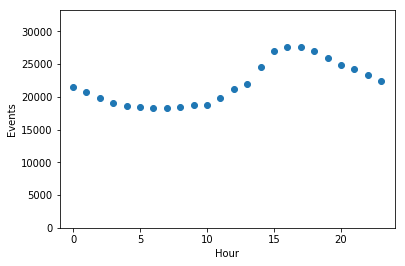

In [42]:
# Plot the events per hour aggregation
plt.scatter(songs_by_hour_pd['hour'], songs_by_hour_pd['count'])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_by_hour_pd['count']))
plt.xlabel('Hour')
plt.ylabel('Events');

### Churned vs Stayed Users

First, we will separate the users who delete their accounts from the users that sticked to the music service. We will use these information for the creation of features later and to calculate aggregated metrics on the gender and song count.

In [43]:
# Get churned and stayed user sets
churned_collect = df.where(df.label==1).select('userId').collect()
churned_users = set([int(row.userId) for row in churned_collect])
churned_df = df.where(F.col('userId').isin(churned_users))

all_collect = df.select('userId').collect()
all_users = set([int(row.userId) for row in all_collect])

stayed_users = all_users-churned_users
stayed_df =  df.where(F.col('userId').isin(stayed_users))

#### Song Count

In [44]:
# Compute average song count per churned user
avg_songs_churned = churned_df.filter(df.page=='NextSong').count()/len(churned_users)
print(avg_songs_churned)

852.1111111111111


In [45]:
# Compute average song count per stayed user
avg_songs_stayed = stayed_df.filter(df.page=='NextSong').count()/len(stayed_users)
print(avg_songs_stayed)

998.6189111747851


#### Gender

In [46]:
# Get gender proportions for churned users
churned_df.dropDuplicates(subset = ['userId']).groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     M|   54|
|     F|   45|
+------+-----+



In [47]:
# Get gender proportions for stayed users
stayed_df.dropDuplicates(subset = ['userId']).groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     M|  196|
|     F|  153|
+------+-----+



# Feature Engineering

Feature engineering plays a key role in big data analytics. Machine learning and data mining algorithms cannot work without data. Little can be achieved if there are few features to represent the underlying data objects, and the quality of results of those algorithms largely depends on the quality of the available features.   
Accordingly, we start building out the features we find promising to train the model on.

In [48]:
# Create features dataframe
feature_df = spark.createDataFrame(all_users, IntegerType()).withColumnRenamed('value', 'userId')

### Create Gender and Account Level Features

In [49]:
# Create binary gender column
convert_gender = F.udf(lambda x: 1 if x == 'M' else 0, IntegerType())
df = df.withColumn('GenderBinary', convert_gender('Gender'))

# Add gender as feature
feature_df = feature_df.join(df.select(['userId', 'GenderBinary']), 'userId') \
    .dropDuplicates(subset=['userId']) \
    .sort('userId')

In [50]:
# Create binary customer level column
convert_level = F.udf(lambda x: 1 if x == 'free' else 0, IntegerType())
df = df.withColumn('LevelBinary', convert_level('Level'))

# Add customer level as feature
feature_df = feature_df.join(df.select(['userId', 'ts', 'LevelBinary']), 'userId') \
    .sort(F.desc('ts')) \
    .dropDuplicates(subset=['userId']) \
    .drop('ts')

### Create Label 

In [51]:
# Create label column
create_churn = F.udf(lambda x: 1 if x in churned_users else 0, IntegerType())
feature_df = feature_df.withColumn('label', create_churn('userId'))

### Create Features on Page Views

In [52]:
# Create a dictonary which maps page views and PySpark dataframes 
pages = {}
pages['neutralPages'] = df.filter((df.page == 'Cancel') | (df.page == 'Home') | (df.page == 'Logout') \
    | (df.page == 'Save Settings') | (df.page == 'About') | (df.page == 'Settings'))
pages['negativePages'] = df.filter((df.page == 'Thumbs Down') | (df.page == 'Roll Advert') | (df.page == 'Help') \
    | (df.page == 'Error'))
pages['positivePages'] = df.filter((df.page == 'Add to Playlist') | (df.page == 'Add Friend') | (df.page == 'NextSong') \
    | (df.page == 'Thumbs Up'))
pages['downgradePages'] = df.filter((df.page == 'Submit Downgrade') | (df.page == 'Downgrade'))
pages['upgradePages'] = df.filter((df.page == 'Upgrade') | (df.page == 'Submit Upgrade'))

In [53]:
# Loop through page views and aggregate the counts by user
for key, value in pages.items():
    value_df = value.select('userId') \
        .groupBy('userId') \
        .agg({'userId':'count'}) \
        .withColumnRenamed('count(userId)', key)
    
    # Add page view aggregations as features
    feature_df = feature_df.join(value_df, 'userId', 'left').sort('userId') \
        .fillna({key:'0'})

In [54]:
def delta_time(x, y):
    '''
    This function computes the timedelta in days between two unix timestamps.
    
    INPUT:
    x, y - timestamps
    
    OUTPUT:
    Timedelta in days    
    '''
    val1 = datetime.datetime.fromtimestamp(x/1000.0)
    val2 = datetime.datetime.fromtimestamp(y/1000.0)
    delta = val2-val1
    delta_days = delta.days
    if delta_days == 0:
        return 1
    return delta_days

# Create UDF for delta_time
delta = F.udf(delta_time, IntegerType())

In [55]:
# Create dataframe with users and first timestamp
min_date_df =  df.select('userId', 'ts') \
    .groupby('userId') \
    .agg(F.min('ts'))

# Create dataframe with users and last timestamp
max_date_df = df.select('userId', 'ts') \
    .groupby('userId') \
    .agg(F.max('ts'))

# Create dataframe which contains time in days between first and last timestamp per user
delta_df = min_date_df.join(max_date_df, 'userId')
delta_df = delta_df.withColumn('UserActiveTime', delta('min(ts)', 'max(ts)')).drop('min(ts)', 'max(ts)')

# Add UserActiveTime as feature
feature_df = feature_df.join(delta_df, 'userId', 'left').sort('userId') \
    .fillna({key:'1'})

In [56]:
# Create dataframe with users and date counts
dateCount_df = df.select('userId', 'date') \
    .groupby('userId') \
    .agg(F.countDistinct('date')) \
    .withColumnRenamed('count(DISTINCT date)', 'dateCount')

# Add date count as feature
feature_df = feature_df.join(dateCount_df, 'userId', 'left').sort('userId') \
        .fillna({'dateCount':'1'})

In [57]:
# Normalize the page view features by dividing through UserActiveTime
for i in ['neutralPages', 'negativePages', 'positivePages', 'downgradePages', 'upgradePages', 'dateCount']:
    feature_df = feature_df.withColumn(i+'Normalized', feature_df[i]/feature_df.UserActiveTime).drop(i)

### Create Features on User Activity by Hour and by Day

In [58]:
# Create dataframe with users and mean hour
hour_df = df.select('userId', 'hour') \
    .groupby('userId') \
    .agg({'hour': 'mean'}) \
    .withColumnRenamed('avg(hour)', 'hourAvg')

# Add mean hour as feature
feature_df = feature_df.join(hour_df, 'userId')

### Encode User Activity over Time as Slope Feature

In [59]:
# Create dataframe with users and their activity per day
activity_df = df.select('userId', 'date') \
    .groupby('userID', 'date') \
    .count()

# Create Spark dataframe with all users
activity_user = spark.createDataFrame(all_users, IntegerType()).withColumnRenamed('value', 'userId')

In [62]:
# initialize slopes
slopes = []
for user in all_users:
    # Create pandas dataframe for slope calculation
    activity_pandas = activity_df.filter(activity_df['userID'] == user).sort(F.asc('date')).toPandas()
    if activity_pandas.shape[0]==1:
        slopes.append(0)
        continue
    # Fit a line through the user activity counts and retrieve its slope
    slope = np.polyfit(activity_pandas.index, activity_pandas['count'], 1)[0]
    slopes.append(slope)

In [63]:
def outliers_iqr(data):
    '''
    This function returns the indices of outliers in data.
    
    INPUT:
    data - list containing values
    
    OUTPUT:
    Outlier indices    
    '''
    avg = np.mean(data)
    lower_bound = avg - 2*np.std(data)
    upper_bound = avg + 2*np.std(data)
    return np.where((data > upper_bound) | (data < lower_bound))

# Set outlier slopes to zero
for i in outliers_iqr(slopes)[0]:
    slopes[i] = 0

In [64]:
# Create dataframe from slopes
slope_df = spark.createDataFrame([float(i) for i in slopes], FloatType()).withColumnRenamed('value', 'Slope')

# Join activity_user and slope_df
activity_user = activity_user.withColumn("row_idx", F.monotonically_increasing_id())
slope_df = slope_df.withColumn("row_idx", F.monotonically_increasing_id())
user_slopes = activity_user.join(slope_df, activity_user.row_idx == slope_df.row_idx).\
             drop("row_idx")

# Add slopes as feature
feature_df = feature_df.join(user_slopes, 'userId').sort('userId')

### Feature Scaling, Merge Columns to one Features Vector

In [65]:
# UDF for converting column type from vector to double type
unlist = F.udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterate over columns to be scaled
for i in ['neutralPagesNormalized', 'negativePagesNormalized', 'positivePagesNormalized', \
          'downgradePagesNormalized', 'upgradePagesNormalized', 'dateCountNormalized', \
         'hourAvg', 'UserActiveTime', 'Slope']:
    # VectorAssembler Transformation - Convert column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    feature_df = pipeline.fit(feature_df).transform(feature_df) \
        .withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

# Merge columns to one feature vector
assembler = VectorAssembler(inputCols=['neutralPagesNormalized_Scaled', 'negativePagesNormalized_Scaled', 'positivePagesNormalized_Scaled', \
                                        'downgradePagesNormalized_Scaled', 'upgradePagesNormalized_Scaled', 'dateCountNormalized_Scaled', \
                                        'hourAvg_Scaled', 'UserActiveTime_Scaled', 'Slope_Scaled', 'LevelBinary', \
                                       'GenderBinary'], outputCol='features')
feature_df = assembler.transform(feature_df)

# Modeling

After the creation of features, we can move on and split the full dataset into training and testing. We will test out several common machine learning methods used for classification tasks. The accuracy of the models will be evaluated and parameters tuned accordingly. Based on the F1-Score, Precision, Recall and ROC Area we will determine the winning model.

### Split Dataset

In [117]:
# Read in the features dataframe and split it into training and testing
train, test = feature_df.randomSplit([0.7, 0.3], seed = 42)

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 322
Test Dataset Count: 126


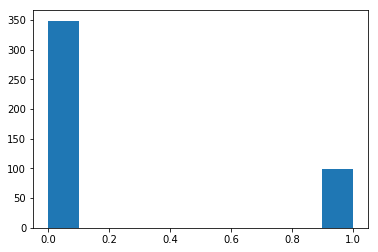

In [118]:
# Check for imbalance in the label distribution
plt.hist(feature_df.toPandas()['label'])
plt.show()

The histogram above depicts that the classes (stayed and churned users) are not represented equally. 

### Machine Learning Hyperparameter Tuning and Evaluation

Spark's MLlib supports tools for model selection such as `CrossValidator`. This requires an estimator, a set of parameters and an evaluator. The estimators and parameters will be set for each classifier specifically. For evaluation, we take the `BinaryClassificationEvaluator` which supports both the 'areaUnderROC' and the 'areaUnderPR'. Since we have a class imbalance in the data, we take the 'areaUnderPR' as our evaluation metric (cf. http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf).

In terms of evaluation, Spark's MLlib provides metrics to assess the performance of the trained machine learning algorithms.

However, the class `BinaryClassificationEvaluator` from pyspark.ml.evaluation only provides the metrics 'areaUnderPR' and 'areaUnderROC'. Therefore, we will compute the F1-Score, Precision and Recall with `sklearn`.

In [162]:
# Create binary evaluator object
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR')

### Logistic Regression

In [131]:
# Calculate a balancing ratio to account for the class imbalance
balancing_ratio = train.filter(train['label']==0).count()/train.count()
train=train.withColumn("classWeights", F.when(train.label == 1,balancing_ratio).otherwise(1-balancing_ratio))

# Create a logistic regression object
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', weightCol="classWeights")

The spark.ml implementation of logistic regression also supports extracting a summary of the model over the training set.

In [163]:
# Train the logistic regression model without parameter tuning
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

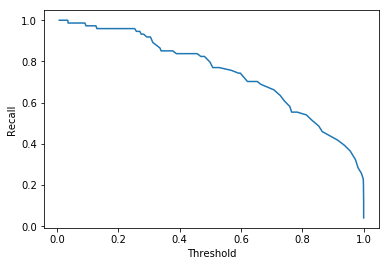

In [169]:
# Plot the threshold-recall curve
tr = trainingSummary.recallByThreshold.toPandas()
plt.plot(tr['threshold'], tr['recall'])
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

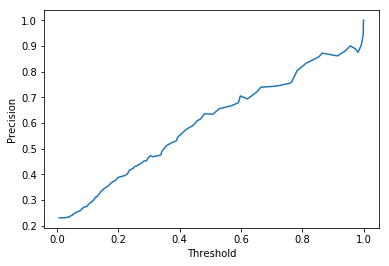

In [172]:
# Plot the threshold-precision curve
tp = trainingSummary.precisionByThreshold.toPandas()
plt.plot(tp['threshold'], tp['precision'])
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

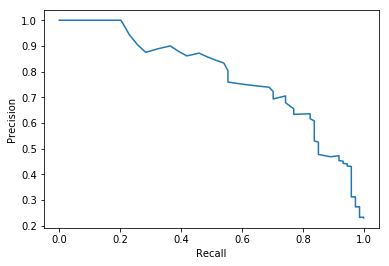

In [164]:
# Plot the recall-precision curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

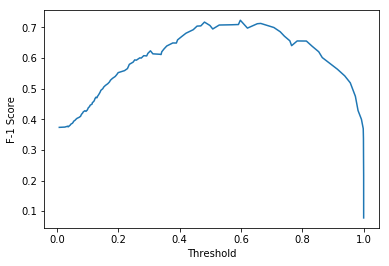

In [165]:
# Plot the threshold-F-Measure curve
fm = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(fm['threshold'], fm['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-1 Score')
plt.show()

In [166]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
predictions_pandas = predictions.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(predictions))

Test Area Under PR:  0.5827013076434557


In [167]:
# Calculate and print f1, recall and precision scores
f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction)
recall = recall_score(predictions_pandas.label, predictions_pandas.prediction)
precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)

print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision)) 

F1-Score: 0.6562499999999999, Recall: 0.84, Precision: 0.5384615384615384


### Gradient-Boosted Tree Classifier

Boosting algorithms are generally good choices for class imbalanced data. PySpark's MLlib supports the Gradient-Boosted Tree classifier, so let's try it on our dataset.

In [173]:
# Create gradient-boosted tree classifier object
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label')

In [176]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
predictions_pandas = predictions.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(predictions))

Test Area Under PR:  0.5961126073635212


In [177]:
# Calculate and print f1, recall and precision scores
f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction)
recall = recall_score(predictions_pandas.label, predictions_pandas.prediction)
precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)

print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision)) 

F1-Score: 0.5833333333333334, Recall: 0.56, Precision: 0.6086956521739131


### Decision Tree Classifier

Decision trees are a popular family of classification and regression methods.

In [178]:
# Create decision tree classifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')

In [179]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 4, 6])
             .addGrid(dt.maxBins, [20, 60])
             .addGrid(dt.impurity, ['gini', 'entropy'])
             .build())
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
predictions_pandas = predictions.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(predictions))

Test Area Under PR:  0.3853345736389214


In [180]:
# Calculate and print f1, recall and precision scores
f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction)
recall = recall_score(predictions_pandas.label, predictions_pandas.prediction)
precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)

print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision)) 

F1-Score: 0.5555555555555556, Recall: 0.6, Precision: 0.5172413793103449


### Support Vector Machines

In [181]:
# Create support vector machine classifier
svm = LinearSVC(featuresCol = 'features', labelCol = 'label')

In [183]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(svm.maxIter, [5, 20])
             .addGrid(svm.regParam, [0.1, 1.0])
             .build())
cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
predictions_pandas = predictions.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(predictions))

Test Area Under PR:  0.5471745496710204


In [184]:
# Calculate and print f1, recall and precision scores
f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction)
recall = recall_score(predictions_pandas.label, predictions_pandas.prediction)
precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)

print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision)) 

F1-Score: 0.24242424242424243, Recall: 0.16, Precision: 0.5


# Conclusion



The goal of this project was to exploit the capabilities of Apache Spark's analytics engine for large-scale data processing to detect customers which are about to stop using Sparkify's music streaming service.

We applied the typical steps of the data science process like gaining understanding about the data, data preparation, modeling and evaluation. The logistic regression model shows the highest performance (F1-Score: 0.66, Recall: 0.84, Precision: 0.54). We are able to recall 84% of the churning customers and can provide them with special offers to keep them from deleting their Sparkify accounts. However, we need to consider a moderate Precision score of 53%. This means that, from all the customers which will receive special offers, 47% of those customers were actually satisfied with the service and would not need any special treatment. 